In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import itertools
import math
import os
import nltk
from nltk.corpus import wordnet as wn

# Reading CSV Files

In [67]:
movies = pd.read_csv(os.getcwd() + "\\movies\\movies.csv")
user_ratings = pd.read_csv(os.getcwd() + "\\movies\\ratings.csv")
user_ratings = user_ratings.sort_values('userId').reset_index(drop = True)

In [68]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,3997,3.5,1112486192
2,1,4011,4.0,1112485406
3,1,4027,4.0,1112485460
4,1,4105,3.5,1094786104


# Preprocess Data

In [5]:
def genre_array(str):
    return str.split('|')

movies['genre'] = movies['genres'].apply(genre_array)
del movies['genres']

movie_col = list(movies.columns)
movie_tags = movies['genre']
tag_table = [ [token, idx] for idx, token in enumerate(set(itertools.chain.from_iterable(movie_tags)))]
tag_table = pd.DataFrame(tag_table)
tag_table.columns = ['Tag', 'Index']

tag_dummy = np.zeros([len(movies), len(tag_table)])

for i in range(len(movies)):
    for j in range(len(tag_table)):
        if tag_table['Tag'][j] in list(movie_tags[i]):
            tag_dummy[i, j] = 1
            
movies = pd.concat([movies, pd.DataFrame(tag_dummy)], 1)
movie_col.extend([string for string in tag_table['Tag']])
movies.columns = movie_col
del movies['genre']

#### Merged Dataset

In [6]:
movielens = pd.merge(user_ratings, movies, on = 'movieId')
movielens.head()

,userId,movieId,rating,timestamp,title,Mystery,War,Musical,Drama,Thriller,...,Romance,Film-Noir,Children,Animation,Crime,Documentary,Comedy,Horror,Adventure,Western
0,1,2,3.5,1112486027,Jumanji (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,2,3.0,851527569,Jumanji (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,13,2,3.0,849082742,Jumanji (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,29,2,3.0,835562174,Jumanji (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,34,2,3.0,846509384,Jumanji (1995),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### List of Movies and their average Rating

In [7]:
data = movielens[['userId', 'movieId', 'title', 'rating']]
movie_list = (((data.sort_values(by = 'movieId')).groupby('title')))['movieId', 'title', 'rating']
movie_list = movie_list.mean()
movie_list['title'] = movie_list.index
movie_list = movie_list.as_matrix()
movie_list = pd.DataFrame(movie_list, columns = ['movieId', 'avgRating', 'title']).sort_values('movieId').reset_index(drop = True)
print (movie_list.shape)
movie_list.head()

(26729, 3)


,movieId,avgRating,title
0,1,3.92124,Toy Story (1995)
1,2,3.21198,Jumanji (1995)
2,3,3.15104,Grumpier Old Men (1995)
3,4,2.86139,Waiting to Exhale (1995)
4,5,3.06459,Father of the Bride Part II (1995)


# Content Based Recommendation

#### Recommendations based on the basis of avgRatings (can be used for New User)

In [8]:
dataset = movielens[:]
ratings_total = dataset.groupby('title').size()

rt = (dataset.groupby('title'))['title','rating']
ratings_mean = (rt.mean())

#modify those dataframes so that we can merge the two 
ratings_total = pd.DataFrame({'movie title':ratings_total.index, 'total ratings': ratings_total.values})
ratings_mean['movie title'] = ratings_mean.index

final = pd.merge(ratings_mean, ratings_total).sort_values(by = 'total ratings', ascending= False)
print(final.head())
print(final.describe())

final = final[:300].sort_values(by = 'rating', ascending = False)
print(final.head())

         rating                       movie title  total ratings
18825  4.174231               Pulp Fiction (1994)          67310
8717   4.029000               Forrest Gump (1994)          66172
20780  4.446990  Shawshank Redemption, The (1994)          63366
20995  4.177057  Silence of the Lambs, The (1991)          63299
12646  3.664741              Jurassic Park (1993)          59715
             rating  total ratings
count  26729.000000   26729.000000
mean       3.133277     748.260803
std        0.664123    3086.673456
min        0.500000       1.000000
25%        2.800000       3.000000
50%        3.235529      18.000000
75%        3.565217     205.000000
max        5.000000   67310.000000
         rating                       movie title  total ratings
20780  4.446990  Shawshank Redemption, The (1994)          63366
9587   4.364732             Godfather, The (1972)          41355
24968  4.334372        Usual Suspects, The (1995)          47006
20318  4.310175           Schindler

# Collaborative Filtering using KNN over Ratings

In [9]:
# dividing the original data into 80:20 ratio
utrain = (user_ratings[:16009595])
utest = (user_ratings[16009595:])

In [10]:
# limiting the size of the data as the longer time on larger dataset
data = user_ratings[:25126]
# dividing the data into 80:20 ratio
train_start = 1
train_end = 160
test_start = 161
test_end = 200
utrain = data[:22508]    # these are 160 users
utest = data[22508:]    # these are 40 users

utrain = utrain.as_matrix(columns = ['userId', 'movieId', 'rating'])
utest = utest.as_matrix(columns = ['userId', 'movieId', 'rating'])

train_list = []
for i in range(train_start, train_end + 1):
    temp_list = []
    for j in range(0, len(utrain)):
        if utrain[j][0] == i:
            temp_list.append(utrain[j])
        else:
            break
    utrain = utrain[j:]
    train_list.append(temp_list)

test_list = []
for i in range(test_start, test_end + 1):
    temp_list = []
    for j in range(0, len(utest)):
        if utest[j][0] == i:
            temp_list.append(utest[j])
        else:
            break
    utest = utest[j:]
    test_list.append(temp_list)
    
def EucledianScore(train_user, test_user):
    sum = 0
    for i in test_user:
        score = 0
        for j in train_user:
            if(int(i[1]) == int(j[1])):
                score += ((float(i[2])-float(j[2]))*(float(i[2])-float(j[2])))
        sum = sum + score
    if sum == 0:
        sum = 10000
    return (math.sqrt(sum))

score_list = []
for i in range(0, test_end - train_end):
    temp_list = []
    for j in range(0, train_end):
        temp_list.append([j+1, EucledianScore(train_list[j], test_list[i])])
    score_list.append(temp_list)
    
score_list = np.array(score_list)
score_list.shape

(40, 160, 2)

#### Users close to userId 161

In [11]:
nearest = 7
temp_score_list = pd.DataFrame(score_list[0], columns = ['user id','Eucledian Score'])
temp_score_list['user id'] = temp_score_list.astype('int')
temp_score_list = temp_score_list.sort_values(by = 'Eucledian Score')
temp_score_list = temp_score_list[:nearest][['user id', 'Eucledian Score']]
temp_score_list

,user id,Eucledian Score
104,105,0.5
49,50,0.5
149,150,0.5
46,47,0.5
144,145,0.5
40,41,0.5
99,100,0.5


### Recommendations

In [12]:
# Taking 7 close users
final_recommendations = []
final_common = []
for i in range(0, test_end - train_end):
    temp_score_list = pd.DataFrame(score_list[i], columns = ['user id','Eucledian Score'])
    temp_score_list['user id'] = temp_score_list.astype('int')
    temp_score_list = temp_score_list.sort_values(by = 'Eucledian Score')
    temp_score_list = temp_score_list[:nearest]['user id'].as_matrix()
    
    full_list = data[data.userId == temp_score_list[0]].movieId.as_matrix()
    for i in range(1, nearest):
        full_list = list(set().union(full_list, data[data.userId == temp_score_list[i]].movieId.as_matrix()))
    full_list = np.array(full_list)
    
    common_list = np.intersect1d(full_list, data[data.userId == i+test_start].movieId.as_matrix())
    common = []
    for i in common_list:
        if(movie_list[movie_list.movieId == i].as_matrix().size != 0):
            common.append(list(movie_list[movie_list.movieId == i].as_matrix()[0]))
    common = (pd.DataFrame(common,columns = ['movieId','mean rating' ,'title'])).sort_values(by = 'mean rating', ascending = False)
    final_common.append(common)
    
    recommendation = np.setdiff1d(full_list, common_list)
    recommendation_list = []
    for i in recommendation:
        if(movie_list[movie_list.movieId == i].as_matrix().size != 0):
            recommendation_list.append(list(movie_list[movie_list.movieId == i].as_matrix()[0]))
    recommendation = (pd.DataFrame(recommendation_list,columns = ['movieId','mean rating' ,'title'])).sort_values(by = 'mean rating', ascending = False)
    final_recommendations.append(recommendation)

#### Common Movies Recommended

In [13]:
for i in range(0, test_end - train_end):
    print ("\n Common for user: ", i+test_start, " -> ", final_common[i].shape[0], "\n", final_common[i][:5][['mean rating' ,'title']])


 Common for user:  161  ->  16 
     mean rating                                              title
2      4.446990                   Shawshank Redemption, The (1994)
8      4.227123                                  Fight Club (1999)
10     4.203810  Spirited Away (Sen to Chihiro no kamikakushi) ...
1      4.190672          Star Wars: Episode IV - A New Hope (1977)
7      4.187186                                 Matrix, The (1999)

 Common for user:  162  ->  2 
    mean rating                                      title
0     4.190672  Star Wars: Episode IV - A New Hope (1977)
1     3.254837        Hunchback of Notre Dame, The (1996)

 Common for user:  163  ->  6 
    mean rating                                      title
2     4.446990           Shawshank Redemption, The (1994)
1     4.190672  Star Wars: Episode IV - A New Hope (1977)
5     4.178547                             Memento (2000)
4     4.176732                 Princess Bride, The (1987)
0     3.978396          Postman, T

#### New Movies Recommended

In [14]:
for i in range(0, test_end - train_end):
    print ("\n Recommended for user: ", i+test_start, "\n", final_recommendations[i][:5][['mean rating' ,'title']])


 Recommended for user:  161 
      mean rating                                          title
9       4.334372                     Usual Suspects, The (1995)
62      4.310175                        Schindler's List (1993)
180     4.274180    Seven Samurai (Shichinin no samurai) (1954)
102     4.258327                              Casablanca (1942)
104     4.256935  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)

 Recommended for user:  162 
      mean rating                             title
24      4.334372        Usual Suspects, The (1995)
128     4.177057  Silence of the Lambs, The (1991)
75      4.174231               Pulp Fiction (1994)
189     4.139730      Boot, Das (Boat, The) (1981)
133     4.112359                      Fargo (1996)

 Recommended for user:  163 
      mean rating                           title
92      4.364732           Godfather, The (1972)
13      4.334372      Usual Suspects, The (1995)
58      4.310175         Schindler's List (1993)
136     4.275641  God

# Collaborative Filtering using KNN over Genres

In [15]:
good_data = movielens[movielens.rating >= 3.5]
data = good_data[:]
data = data.groupby('userId').aggregate(np.sum)
del data['movieId']
del data['rating']
del data['timestamp']
data.head()

,Mystery,War,Musical,Drama,Thriller,IMAX,(no genres listed),Fantasy,Action,Sci-Fi,Romance,Film-Noir,Children,Animation,Crime,Documentary,Comedy,Horror,Adventure,Western
userId,,,,,,,,,,,,,,,,,,,,
1,18.0,9.0,3.0,41.0,41.0,2.0,0.0,64.0,56.0,37.0,11.0,0.0,17.0,9.0,20.0,0.0,39.0,43.0,64.0,2.0
2,4.0,4.0,0.0,12.0,16.0,0.0,0.0,0.0,19.0,22.0,4.0,1.0,0.0,0.0,1.0,0.0,6.0,10.0,17.0,2.0
3,9.0,6.0,4.0,48.0,43.0,0.0,0.0,18.0,47.0,67.0,13.0,0.0,9.0,3.0,17.0,1.0,37.0,23.0,41.0,2.0
4,1.0,1.0,2.0,5.0,6.0,0.0,0.0,2.0,6.0,2.0,2.0,0.0,3.0,2.0,1.0,0.0,6.0,0.0,4.0,1.0
5,1.0,1.0,6.0,21.0,12.0,3.0,0.0,5.0,16.0,9.0,9.0,0.0,7.0,5.0,4.0,0.0,16.0,0.0,17.0,2.0


In [16]:
target = pd.DataFrame(sorted(good_data['userId'].unique()))
data = data.set_index([[i for i in range(138362)]])

In [17]:
data.shape

(138362, 20)

In [18]:
target.shape

(138362, 1)

In [39]:
temp_target = target[:200]
temp_data = data[:200]
# dividing in 80:20 ratio
train_start = 1
train_end = 160
test_start = 161
test_end = 200

def distance(X_Train, X_Test):
        res = (X_Train - X_Test)**2
        res = res.sum()
        return np.round(res**0.5, decimals = 1)

def predict_iter(X_Train, Y_Train, X_Test, k):
        distances = []
        for i in range(X_Train.shape[0]):
            d = distance(X_Train[i], X_Test)
            distances.append((d, i))
        distances = sorted(distances, key = lambda distances: distances[0])
        knearestneighbors = np.array(distances[:k])
        y_predicted = np.array([ x[1]  for x in knearestneighbors ], dtype = int)
        y_predicted = Y_Train[y_predicted]
        
        return knearestneighbors
    
def predict(X_Train, Y_Train, X_Test, k = 7):
        y_predicted = []
        for i in X_Test:
            y_predicted.append(predict_iter(X_Train, Y_Train, i, k))
        y_predicted = np.array(y_predicted)
        return y_predicted
        
X_Train = temp_data[:train_end].as_matrix()
X_Test = temp_data[test_start-1:].as_matrix()
Y_Train = temp_target[:train_end].as_matrix()
Y_Test = temp_target[test_start-1:].as_matrix()
print (X_Train.shape)
print (X_Test.shape)
print (Y_Train.shape)
print (Y_Test.shape)
y_predicted = predict(X_Train, Y_Train, X_Test)
print ('\n Predicted array : ', y_predicted)

(160, 20)
(40, 20)
(160, 1)
(40, 1)

 Predicted array :  [[[   4.6  122. ]
  [   5.5   51. ]
  [   5.7   29. ]
  [   6.5   27. ]
  [   6.9   35. ]
  [   7.1   86. ]
  [   7.1  145. ]]

 [[  34.3  151. ]
  [  38.2  135. ]
  [  40.    89. ]
  [  43.3    6. ]
  [  44.5   68. ]
  [  44.6    2. ]
  [  46.3   97. ]]

 [[  16.    41. ]
  [  16.8  154. ]
  [  18.4  114. ]
  [  18.9  126. ]
  [  19.6   98. ]
  [  20.4    7. ]
  [  21.8   64. ]]

 [[  17.9  126. ]
  [  20.2   74. ]
  [  20.4   41. ]
  [  21.3  127. ]
  [  22.1    7. ]
  [  23.5  154. ]
  [  24.2  116. ]]

 [[   8.1   14. ]
  [   9.2   93. ]
  [  10.1  112. ]
  [  10.2   78. ]
  [  10.4   79. ]
  [  10.4  149. ]
  [  10.8  119. ]]

 [[   7.5  149. ]
  [   7.6   67. ]
  [   8.2   79. ]
  [   8.2  125. ]
  [   8.5    3. ]
  [   8.6    5. ]
  [   9.1   19. ]]

 [[  13.6   43. ]
  [  13.6   83. ]
  [  14.2  150. ]
  [  15.    63. ]
  [  15.8   11. ]
  [  16.2   18. ]
  [  16.7   85. ]]

 [[  32.8  151. ]
  [  33.6   24. ]
  [  34.4  

In [23]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 7)
KNN.fit(X_Train, Y_Train)
distances, neighbors = KNN.kneighbors(X_Test)

C:\Users\dhruv\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = 0
for i in range(test_end - train_end):
    rms += sqrt(mean_squared_error(distances[i], y_predicted[i][:, 0]))
print ("\n\t Root Mean Square Error : ", rms)


	 Root Mean Square Error :  0.11561596865363359


### For Test user 161

###### Predicted using Implemented Model

In [40]:
print (y_predicted[0][:, 0])
print (y_predicted[0][:, 1])

[ 4.6  5.5  5.7  6.5  6.9  7.1  7.1]
[ 122.   51.   29.   27.   35.   86.  145.]


###### Predicted using Standard Model

In [41]:
print (distances[0])
print (neighbors[0])

[ 4.58257569  5.47722558  5.74456265  6.4807407   6.8556546   7.07106781
  7.14142843]
[122  51  29  27  35  86 145]


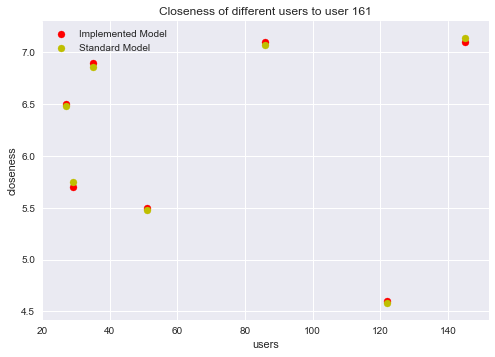

In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.figure(figsize = (5,5))
fig, ax = plt.subplots( nrows=1, ncols=1 )
plt.scatter(y_predicted[0][:, 1], y_predicted[0][:, 0], color = 'r', label = 'Implemented Model')
plt.scatter(neighbors[0], distances[0], color = 'y', label = 'Standard Model')
plt.xlabel("users")
plt.ylabel("closeness")
plt.title("Closeness of different users to user 161")
plt.legend()
plt.show()
fig.savefig("closeness.png")

In [43]:
new_list = []
for i in range(test_end - train_end):
    x = y_predicted[i][:, 1]
    x = np.array(x, dtype = int)
    new_list.append(Y_Train[x].ravel())
y_predicted = np.array(new_list)
y_predicted

array([[123,  52,  30,  28,  36,  87, 146],
       [152, 136,  90,   7,  69,   3,  98],
       [ 42, 155, 115, 127,  99,   8,  65],
       [127,  75,  42, 128,   8, 155, 117],
       [ 15,  94, 113,  79,  80, 150, 120],
       [150,  68,  80, 126,   4,   6,  20],
       [ 44,  84, 151,  64,  12,  19,  86],
       [152,  25, 153,  61,  23, 102,  21],
       [103, 129,  25, 144,  46, 112, 109],
       [ 61, 152, 109, 153, 134, 129,  25],
       [ 20,   4, 105, 126,  68,  80,  94],
       [ 52,  30,  68, 146,  28,  80,  95],
       [ 92, 118, 120,  94,  26,   6,  80],
       [ 12,  94,   6, 111, 150,   4,  57],
       [101,  72, 102, 158, 117,  48,  74],
       [111, 113,  45,  12,   6, 120,  44],
       [ 80,   6,  52,  68, 126,  30,   4],
       [ 38, 131, 108, 114,  45,  88,  40],
       [ 52,  28,   6,  30, 123, 146,  80],
       [ 20,   4,  39,  47,  94,  12, 126],
       [ 12,   6,   4,  20, 105,  94,  47],
       [ 22, 127,  75,  77,  42,  98,   2],
       [143,  17,  39,  20,  86,

In [44]:
print ("Users close to userId 161 : ")
y_predicted[0]

Users close to userId 161 : 


array([123,  52,  30,  28,  36,  87, 146], dtype=int64)

In [45]:
nearest = 7
final_recommendations_knn = []
final_common_knn = []
for i in range(0, test_end - train_end):
    temp_list = y_predicted[i]
    full_list = good_data[good_data.userId == temp_list[0]].movieId.as_matrix()
    for i in range(1, nearest):
        full_list = list(set().union(full_list, good_data[good_data.userId == temp_list[i]].movieId.as_matrix()))
    full_list = np.array(full_list)
    
    common_list = np.intersect1d(full_list, good_data[good_data.userId == i+test_start].movieId.as_matrix())
    common = []
    for i in common_list:
        if(movie_list[movie_list.movieId == i].as_matrix().size != 0):
            common.append(list(movie_list[movie_list.movieId == i].as_matrix()[0]))
    common = (pd.DataFrame(common,columns = ['movieId','mean rating' ,'title'])).sort_values(by = 'mean rating', ascending = False)
    final_common_knn.append(common)
    
    recommendation = np.setdiff1d(full_list, common_list)
    recommendation_list = []
    for i in recommendation:
        if(movie_list[movie_list.movieId == i].as_matrix().size != 0):
            recommendation_list.append(list(movie_list[movie_list.movieId == i].as_matrix()[0]))
    recommendation = (pd.DataFrame(recommendation_list,columns = ['movieId','mean rating' ,'title'])).sort_values(by = 'mean rating', ascending = False)
    final_recommendations_knn.append(recommendation)

In [46]:
for i in range(0, test_end - train_end):
    print ("\n Common for user: ", i+test_start, " -> ", final_common_knn[i].shape[0], "\n", final_common_knn[i][:5][['mean rating' ,'title']])


 Common for user:  161  ->  1 
    mean rating                             title
0      4.44699  Shawshank Redemption, The (1994)

 Common for user:  162  ->  17 
     mean rating                                      title
1      4.446990           Shawshank Redemption, The (1994)
6      4.227123                          Fight Club (1999)
13     4.220129                    Dark Knight, The (2008)
0      4.190672  Star Wars: Episode IV - A New Hope (1977)
5      4.187186                         Matrix, The (1999)

 Common for user:  163  ->  17 
     mean rating                                              title
1      4.446990                   Shawshank Redemption, The (1994)
4      4.227123                                  Fight Club (1999)
2      4.224138                                12 Angry Men (1957)
13     4.220129                            Dark Knight, The (2008)
9      4.203810  Spirited Away (Sen to Chihiro no kamikakushi) ...

 Common for user:  164  ->  11 
     mean ra

In [47]:
for i in range(0, test_end - train_end):
    print ("\n Recommended for user: ", i+test_start, "\n", final_recommendations_knn[i][:5][['mean rating' ,'title']])


 Recommended for user:  161 
     mean rating                                       title
2      4.334372                  Usual Suspects, The (1995)
31     4.177057            Silence of the Lambs, The (1991)
41     4.175837  Life Is Beautiful (La Vita è bella) (1997)
14     4.174231                         Pulp Fiction (1994)
3      4.042534                           Braveheart (1995)

 Recommended for user:  162 
      mean rating                           title
79      4.364732           Godfather, The (1972)
10      4.334372      Usual Suspects, The (1995)
51      4.310175         Schindler's List (1993)
119     4.275641  Godfather: Part II, The (1974)
81      4.271334              Rear Window (1954)

 Recommended for user:  163 
      mean rating                                        title
85      4.364732                        Godfather, The (1972)
13      4.334372                   Usual Suspects, The (1995)
59      4.310175                      Schindler's List (1993)
129  

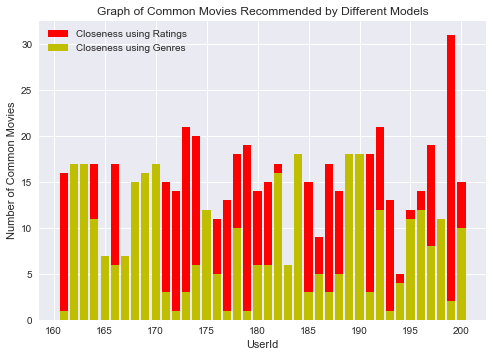

In [48]:
collab_common = []
knn_common = []
users = []
for i in range(0, test_end - train_end):
    users.append(i+test_start)
    collab_common.append(final_common[i].shape[0])
    knn_common.append(final_common_knn[i].shape[0])
plt.figure(figsize = (15, 5))
fig, ax = plt.subplots( nrows=1, ncols=1 )
plt.bar(users, collab_common, color = 'r', label = 'Closeness using Ratings')
plt.bar(users, knn_common, color = 'y', label = 'Closeness using Genres')
plt.xlabel('UserId')
plt.ylabel('Number of Common Movies')
plt.title('Graph of Common Movies Recommended by Different Models')
plt.legend()
plt.show()
fig.savefig("common_movies.png")

# Books Dataset Combining

### Preprocess Data

In [75]:
books = pd.read_csv(os.getcwd() + "\\books\\booksummaries.txt", sep='\t', names=['Wikipedia_ID', 'Freebase_ID', 'Title', 'Author', 'Pub_Date', 'Genre', 'Plot'])
books.dropna(subset=['Genre'], inplace = True)
del books['Freebase_ID']
del books['Plot']
import ast
def getGenre(str):
    return list(ast.literal_eval(str).values())

books['Genre'] = books['Genre'].apply(getGenre)
books.reset_index(inplace = True, drop = True)
books.head()

,Wikipedia_ID,Title,Author,Pub_Date,Genre
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N..."
3,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul..."
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]"


In [50]:
books_tags = books['Genre']
tag_table_books = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(books_tags)))]
tag_table_books = pd.DataFrame(tag_table_books)
tag_table_books.columns = ['Tag']

tag_books = tag_table_books.as_matrix().ravel()
tag_movies = tag_table['Tag'].as_matrix()

In [51]:
tag_books

array(['Juvenile fantasy', 'Spirituality', 'Utopian and dystopian fiction',
       'Self-help', 'Political philosophy', 'Popular science',
       'Social science fiction', 'Elizabethan romance', 'Gay Themed',
       'Steampunk', 'Western fiction', 'High fantasy',
       'Zombies in popular culture', 'Military science fiction',
       'Comic book', 'American Gothic Fiction', 'Marketing',
       'Travel literature', 'Subterranean fiction', 'Black comedy',
       'Social commentary', 'Contemporary fantasy', 'Erotica',
       'Alternate history', 'Literary criticism', 'Military history',
       'Role-playing game', 'Mystery', 'Essay', 'Space western', 'Fiction',
       'Adventure novel', 'Naval adventure', 'Fairy tale', 'Prose poetry',
       'Historical fiction', 'Historical fantasy', 'Adventure',
       'Future history', 'Fictional crossover', 'Roman à clef',
       'Epic Science Fiction and Fantasy', 'Nature', 'Youth',
       'Sword and sorcery', 'Existentialism', 'Human extinction',
  

In [66]:
tag_books.shape

(227,)

In [52]:
tag_movies

array(['Mystery', 'War', 'Musical', 'Drama', 'Thriller', 'IMAX',
       '(no genres listed)', 'Fantasy', 'Action', 'Sci-Fi', 'Romance',
       'Film-Noir', 'Children', 'Animation', 'Crime', 'Documentary',
       'Comedy', 'Horror', 'Adventure', 'Western'], dtype=object)

In [53]:
tag_movies = np.delete(tag_movies, [5,6,9,11])
tag_movies

array(['Mystery', 'War', 'Musical', 'Drama', 'Thriller', 'Fantasy',
       'Action', 'Romance', 'Children', 'Animation', 'Crime',
       'Documentary', 'Comedy', 'Horror', 'Adventure', 'Western'], dtype=object)

In [54]:
def find_relation(str):
    str = str.replace('-', ' ')
    if(len(str.split())==1):
        a = wn.synsets(str)
        if len(a) == 0:
            return 'Null'
        else:
            x = []
            for genre in tag_movies:
                m = wn.synsets(genre)
                x.append(a[0].path_similarity(m[0]))
            x = np.array(x, dtype = float)
            max_idx = x.argmax()
            return tag_movies[max_idx]
    else:
        a = wn.synsets(str.split()[0])
        b = wn.synsets(str.split()[1])
        if len(a) == 0 and len(b) == 0:
            return 'Null'
        elif (len(a) != 0 and len(b) == 0) or (len(a) == 0 and len(b) != 0):
            if len(a) != 0 and len(b) == 0:
                a = wn.synsets(str.split()[0])
            else:
                a = wn.synsets(str.split()[1])
            if len(a) == 0:
                return 'Null'
            else:
                x = []
                for genre in tag_movies:
                    m = wn.synsets(genre)
                    x.append(a[0].path_similarity(m[0]))
                x = np.array(x, dtype = float)
                max_idx = x.argmax()
                return tag_movies[max_idx]
        else:
            x = []
            y = []
            for genre in tag_movies:
                m = wn.synsets(genre)
                x.append(a[0].path_similarity(m[0]))
                y.append(b[0].path_similarity(m[0]))
            x = np.array(x, dtype = float)
            y = np.array(y, dtype = float)
            if (x.max() > y.max()):
                max_idx = x.argmax()
            else:
                max_idx = y.argmax()
            return tag_movies[max_idx]
    
tag_table_books['relation'] = tag_table_books['Tag'].apply(find_relation)
tag_table_books

,Tag,relation
0,Juvenile fantasy,Fantasy
1,Spirituality,Action
2,Utopian and dystopian fiction,Children
3,Self-help,Action
4,Political philosophy,Fantasy
5,Popular science,Fantasy
6,Social science fiction,Fantasy
7,Elizabethan romance,Romance
8,Gay Themed,Children
9,Steampunk,Null


### Book Recommendations for user 161

In [55]:
movie_id = final_recommendations[0][:5][['movieId']].as_matrix().ravel()
movie_id = movie_id.astype(int)

In [56]:
movies = pd.read_csv(os.getcwd() + "\\movies\\movies.csv")
def genre_array(str):
    return str.split('|')

movies['genre'] = movies['genres'].apply(genre_array)
del movies['genres']

In [57]:
filtered_dataset = pd.DataFrame([ movies[movies.movieId == i].as_matrix()[0] for i in movie_id], columns = ['movieId', 'title', 'genre'])
filtered_dataset

,movieId,title,genre
0,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"
1,527,Schindler's List (1993),"[Drama, War]"
2,2019,Seven Samurai (Shichinin no samurai) (1954),"[Action, Adventure, Drama]"
3,912,Casablanca (1942),"[Drama, Romance]"
4,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),"[Drama, Film-Noir, Romance]"


In [58]:
selected_movie_tags = filtered_dataset['genre']
tag_selected_movies = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(selected_movie_tags)))]
tag_selected_movies

['Mystery',
 'War',
 'Drama',
 'Thriller',
 'Romance',
 'Film-Noir',
 'Crime',
 'Action',
 'Adventure']

In [59]:
tag_selected_books = [ tag_table_books[tag_table_books.relation == i].Tag.as_matrix() for i in tag_selected_movies ]
tag_selected_books = [ token for idx, token in enumerate(set(itertools.chain.from_iterable(tag_selected_books)))]
tag_selected_books

['Spirituality',
 'Self-help',
 'Elizabethan romance',
 'Marketing',
 'Travel literature',
 'Subterranean fiction',
 'Social commentary',
 'Erotica',
 'Literary criticism',
 'Military history',
 'Role-playing game',
 'Mystery',
 'Essay',
 'Fiction',
 'Adventure novel',
 'Naval adventure',
 'Fairy tale',
 'Historical fiction',
 'Epic Science Fiction and Fantasy',
 'Future history',
 'Adventure',
 'Nature',
 'Human extinction',
 'Time travel',
 'Police procedural',
 'Conspiracy fiction',
 'Catastrophic literature',
 'Novella',
 'Post-holocaust',
 "Children's literature",
 'Spy fiction',
 'Conspiracy',
 'Sea story',
 'Politics',
 'Parallel novel',
 'School story',
 'Travel',
 'Personal journal',
 'Non-fiction novel',
 'Absurdist fiction',
 'Comic novel',
 'Planetary romance',
 'Fable',
 'Drama',
 'Cabal',
 'Autobiographical novel',
 'History',
 'Space opera',
 'Industrial novel',
 'Picaresque novel',
 'Foreign legion',
 'Religious text',
 'Light novel',
 'Education',
 'Whodunit',
 'Coming

In [60]:
books_col = list(books.columns)
books_tags = books['Genre']
tag_table_books = [ [token, idx] for idx, token in enumerate(set(itertools.chain.from_iterable(books_tags)))]
tag_table_books = pd.DataFrame(tag_table_books)
tag_table_books.columns = ['Tag', 'Index']

tag_dummy_books = np.zeros([len(books), len(tag_table_books)])

for i in range(len(books)):
    for j in range(len(tag_table_books)):
        if tag_table_books['Tag'][j] in list(books_tags[i]):
            tag_dummy_books[i, j] = 1
            
hot_encoded_books = pd.concat([books, pd.DataFrame(tag_dummy_books)], 1)
books_col.extend([string for string in tag_table_books['Tag']])
hot_encoded_books.columns = books_col
hot_encoded_books.head()

,Wikipedia_ID,Title,Author,Pub_Date,Genre,Juvenile fantasy,Spirituality,Utopian and dystopian fiction,Self-help,Political philosophy,...,Superhero fiction,Medieval romance,Non-fiction,Thriller,Sports,Parody,Creative nonfiction,Paranormal romance,Supernatural,Crime Fiction
0,620,Animal Farm,George Orwell,1945-08-17,"[Roman à clef, Satire, Children's literature, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,843,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...",0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,986,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2080,A Fire Upon the Deep,Vernor Vinge,NaN,"[Hard science fiction, Science Fiction, Specul...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
recommended_books = []
counts = np.zeros((hot_encoded_books.shape[0]))
for i in tag_selected_books:
    indices = hot_encoded_books[hot_encoded_books[i] == 1.0].index.tolist()
    for j in indices:
        counts[j] += 1
for i in range(5):
    max_idx = counts.argmax()
    recommended_books.append(max_idx)
    counts[max_idx] = 0
recommended_books = hot_encoded_books.iloc[recommended_books].Title.as_matrix()
recommended_books = np.array(recommended_books)
recommended_books = recommended_books.ravel()
recommended_books

array(['The Time Machine', 'Angels and Demons', 'World War Z',
       'Jungle Tales of Tarzan', 'Dracula'], dtype=object)